Accuracy of the stacked model: 0.90


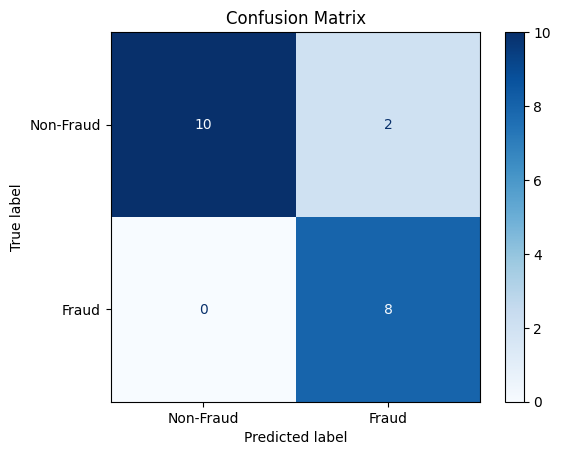

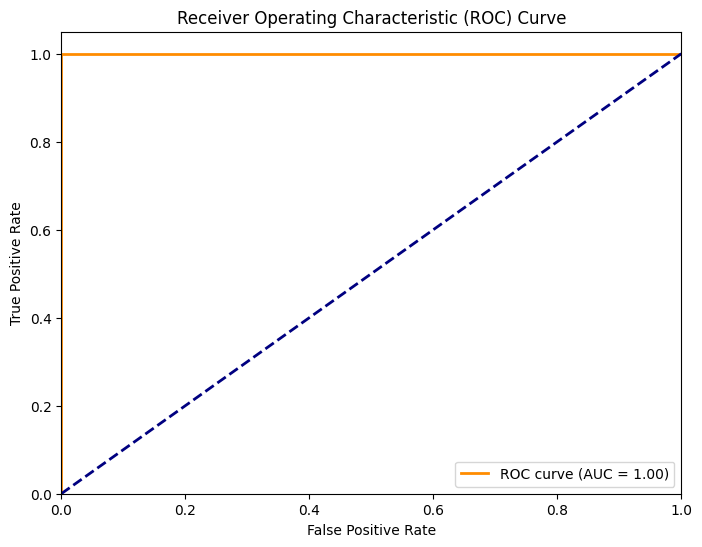

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Step 1: Load the dataset
data = pd.read_csv("/content/drive/MyDrive/balanced_creditcard.csv")
data = data.dropna()  # Remove missing values

# Step 2: Sample the data for faster processing
sample_data = data.sample(frac=0.1, random_state=42)  # Use 10% of data

# Step 3: Separate features and target variable
X = sample_data.drop(columns=['Class'])
y = sample_data['Class']

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Define the base models and their parameter grids for GridSearchCV
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)

# Parameter grids for each model
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, None]
}

param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}

param_grid_svm = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Step 7: Use GridSearchCV to find the best parameters for each model
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, scoring='accuracy', n_jobs=-1)
grid_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grids
grid_rf.fit(X_train, y_train)
grid_gb.fit(X_train, y_train)
grid_svm.fit(X_train, y_train)

# Best estimators from GridSearchCV
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_
best_svm = grid_svm.best_estimator_

# Step 8: Create the stacking ensemble model with the best models
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb),
        ('svm', best_svm)
    ],
    final_estimator=LogisticRegression(),
    cv=3,
    n_jobs=-1
)

# Step 9: Train the stacking model
stacking_model.fit(X_train, y_train)

# Step 10: Make predictions and evaluate the model
y_pred = stacking_model.predict(X_test)
y_proba = stacking_model.predict_proba(X_test)[:, 1]  # Probability estimates for the ROC curve

# Step 11: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the stacked model: {accuracy:.2f}")

# Step 12: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 13: Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Step 14: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


GridStack


Accuracy of the stacked model: 0.90
              precision    recall  f1-score   support

   Non-Fraud       0.92      0.92      0.92        12
       Fraud       0.88      0.88      0.88         8

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



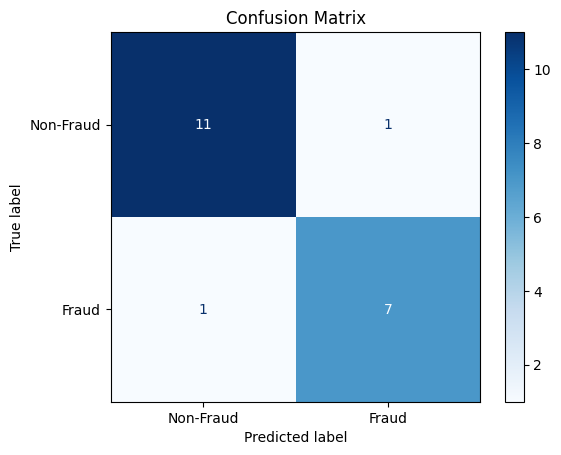

Classification Report with threshold 0.3:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.92      0.96        12
       Fraud       0.89      1.00      0.94         8

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20



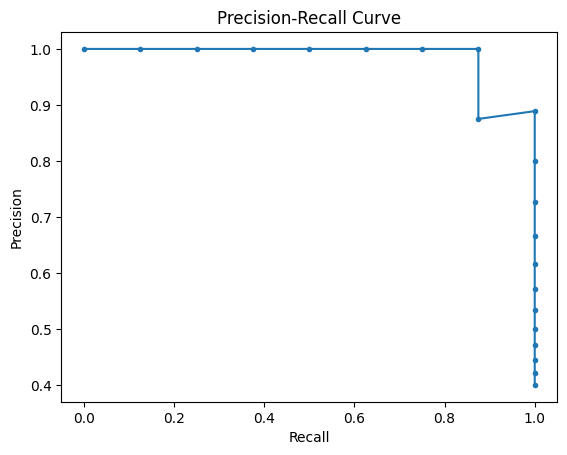

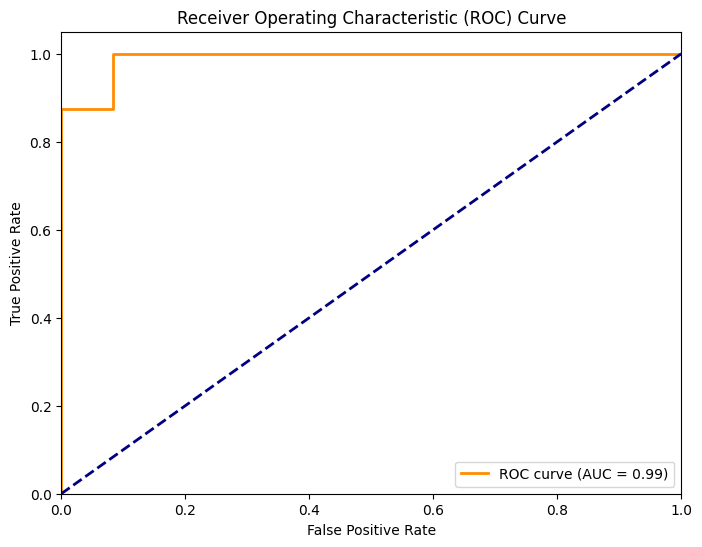

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Load the dataset
data = pd.read_csv("/content/drive/MyDrive/balanced_creditcard.csv")
data = data.dropna()  # Remove missing values

# Step 2: Sample the data for faster processing
sample_data = data.sample(frac=0.1, random_state=42)  # Use 10% of data

# Step 3: Separate features and target variable
X = sample_data.drop(columns=['Class'])
y = sample_data['Class']

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 7: Define the base models with class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svm = SVC(class_weight='balanced', probability=True, random_state=42)

# Parameter grids for each model for GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, None]
}

param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}

param_grid_svm = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Step 8: Use GridSearchCV to find the best parameters for each model
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
grid_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, scoring='f1', n_jobs=-1)
grid_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=3, scoring='f1', n_jobs=-1)

# Fit the grids
grid_rf.fit(X_train_resampled, y_train_resampled)
grid_gb.fit(X_train_resampled, y_train_resampled)
grid_svm.fit(X_train_resampled, y_train_resampled)

# Best estimators from GridSearchCV
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_
best_svm = grid_svm.best_estimator_

# Step 9: Create the stacking ensemble model with the best models
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb),
        ('svm', best_svm)
    ],
    final_estimator=LogisticRegression(),
    cv=3,
    n_jobs=-1
)

# Step 10: Train the stacking model
stacking_model.fit(X_train_resampled, y_train_resampled)

# Step 11: Make predictions and evaluate the model
y_pred = stacking_model.predict(X_test)
y_proba = stacking_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC curve and threshold adjustment

# Step 12: Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the stacked model: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Step 13: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 14: Adjust probability threshold to improve recall
threshold = 0.3  # Adjusted threshold
y_pred_threshold = (y_proba >= threshold).astype(int)

# Recalculate metrics with adjusted threshold
print(f"Classification Report with threshold {threshold}:")
print(classification_report(y_test, y_pred_threshold, target_names=['Non-Fraud', 'Fraud']))

# Step 15: Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Step 16: Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


GridSearch

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94        99
           1       0.95      0.93      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



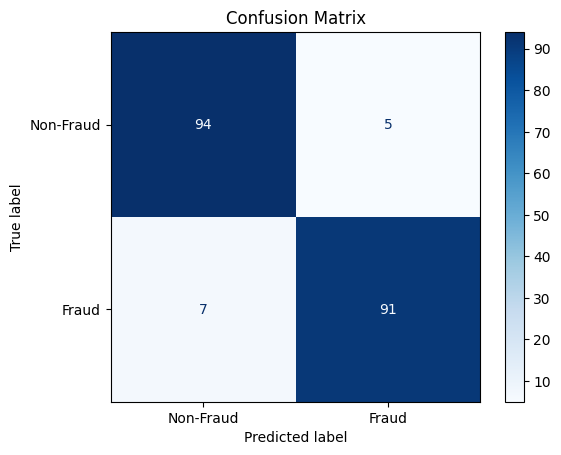

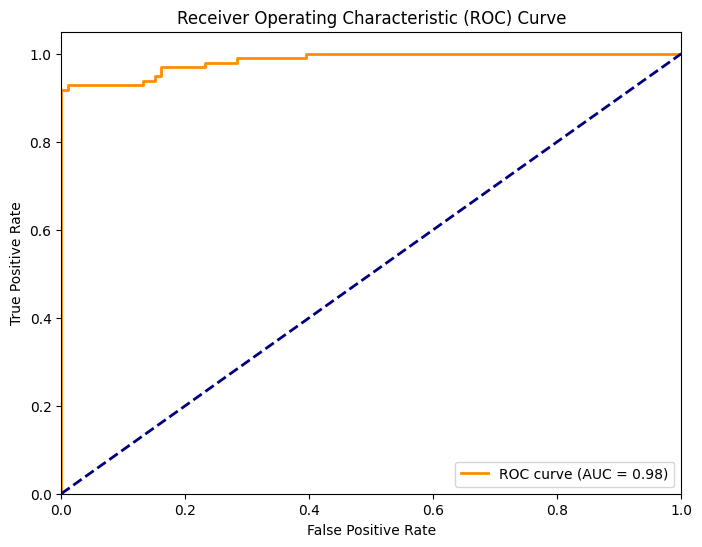

Accuracy: 0.94
Precision: 0.95
Recall: 0.93
F1 Score: 0.94
AUC-ROC: 0.98


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Step 1: Load and preprocess the dataset
data = pd.read_csv("/content/drive/MyDrive/balanced_creditcard.csv")  # Update with the correct path
data = data.dropna()  # Remove missing values if any

# Step 2: Separate features and target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Step 3: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Define base models and parameter grids for GridSearchCV
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)

# Parameter grids for GridSearchCV
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [10, None]}
param_grid_gb = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
param_grid_svm = {'C': [0.1, 1], 'kernel': ['linear', 'rbf']}

# GridSearchCV for each model
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, scoring='accuracy', n_jobs=-1)
grid_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1)

# Fit each grid search
grid_rf.fit(X_train, y_train)
grid_gb.fit(X_train, y_train)
grid_svm.fit(X_train, y_train)

# Get the best estimators from each grid search
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_
best_svm = grid_svm.best_estimator_

# Step 6: Create stacking ensemble model with best base models
stacking_model = StackingClassifier(
    estimators=[('rf', best_rf), ('gb', best_gb), ('svm', best_svm)],
    final_estimator=LogisticRegression(),
    cv=3,
    n_jobs=-1
)

# Step 7: Train the stacking model
stacking_model.fit(X_train, y_train)

# Step 8: Make predictions
y_pred = stacking_model.predict(X_test)
y_proba = stacking_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# Step 9: Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 10: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 11: Compute and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Step 12: Print summary metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")


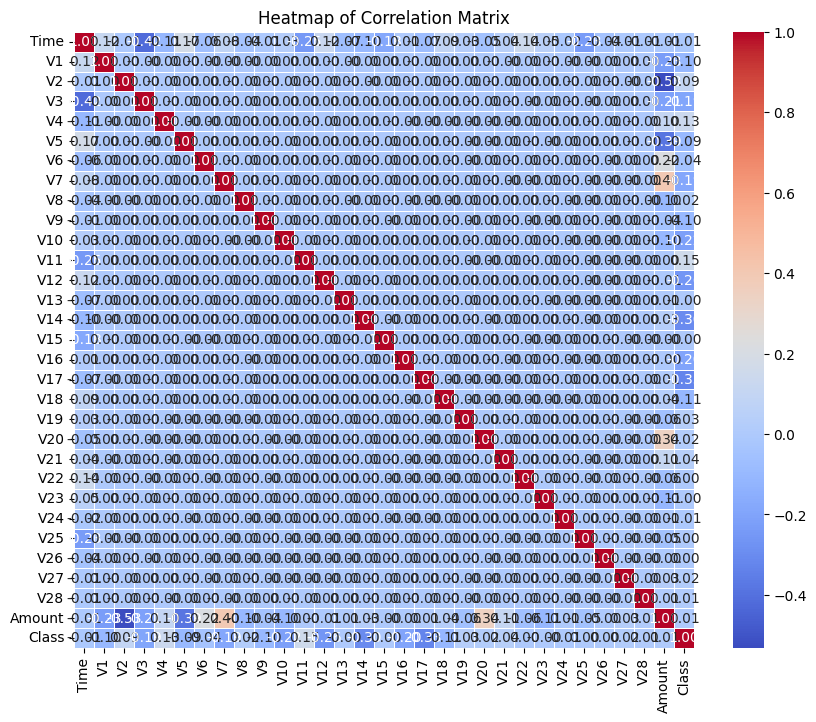

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/creditcard.csv')

# Generate the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title to the heatmap
plt.title('Heatmap of Correlation Matrix')

# Show the heatmap
plt.show()


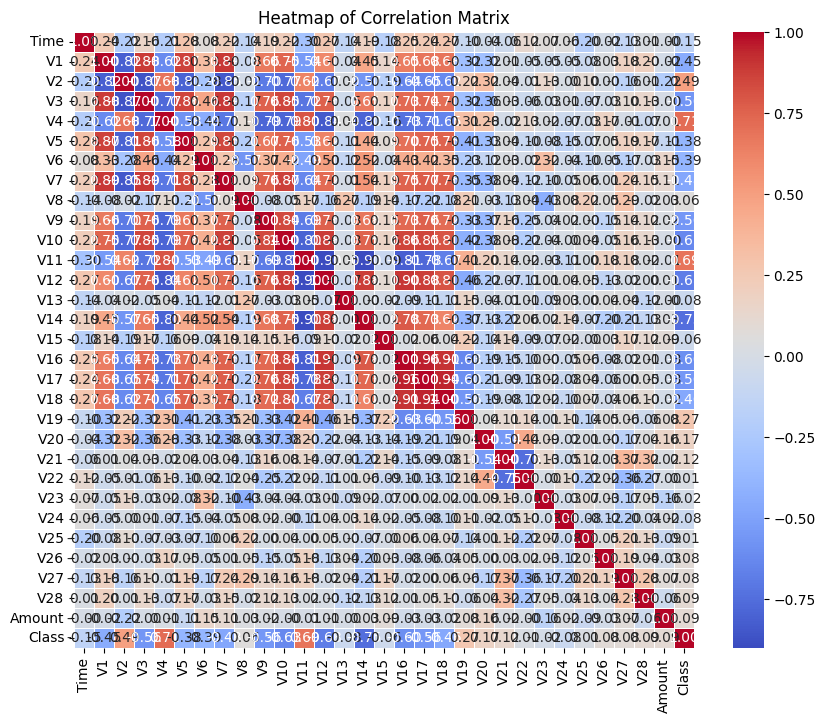

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/balanced_creditcard.csv')

# Generate the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title to the heatmap
plt.title('Heatmap of Correlation Matrix')

# Show the heatmap
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Accuracy of the stacked model: 0.90
              precision    recall  f1-score   support

   Non-Fraud       0.92      0.92      0.92        12
       Fraud       0.88      0.88      0.88         8

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



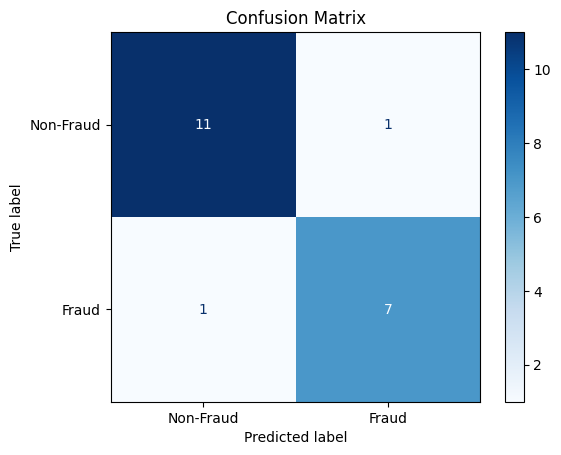

Classification Report with threshold 0.3:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.92      0.96        12
       Fraud       0.89      1.00      0.94         8

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20



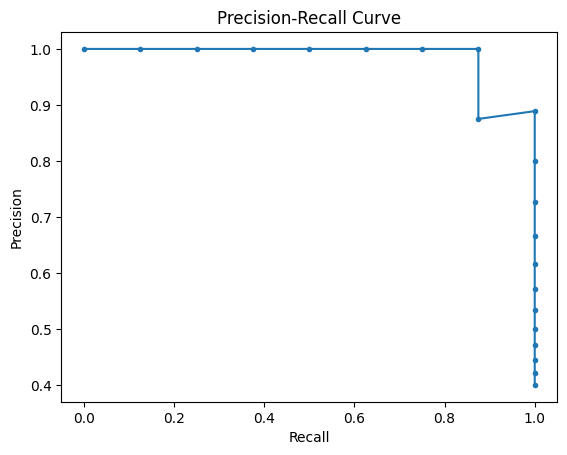

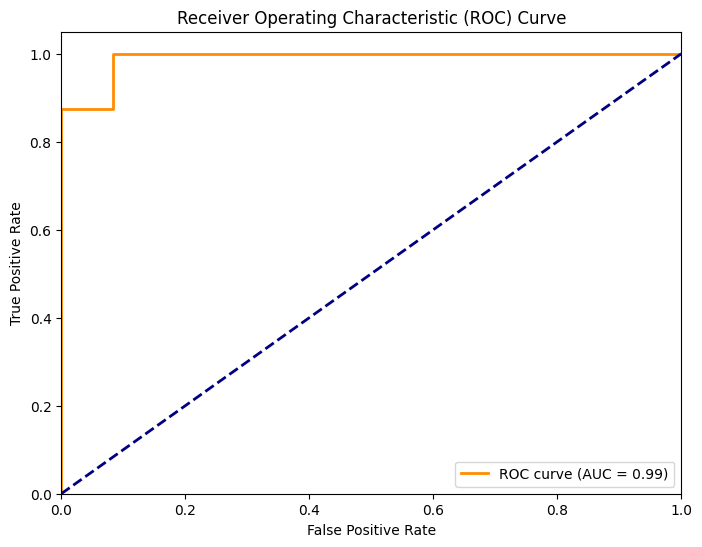

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/joblib/_utils.py", line 72, in __call__
    return self.func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 598, in <listcomp>
    return [func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/skle

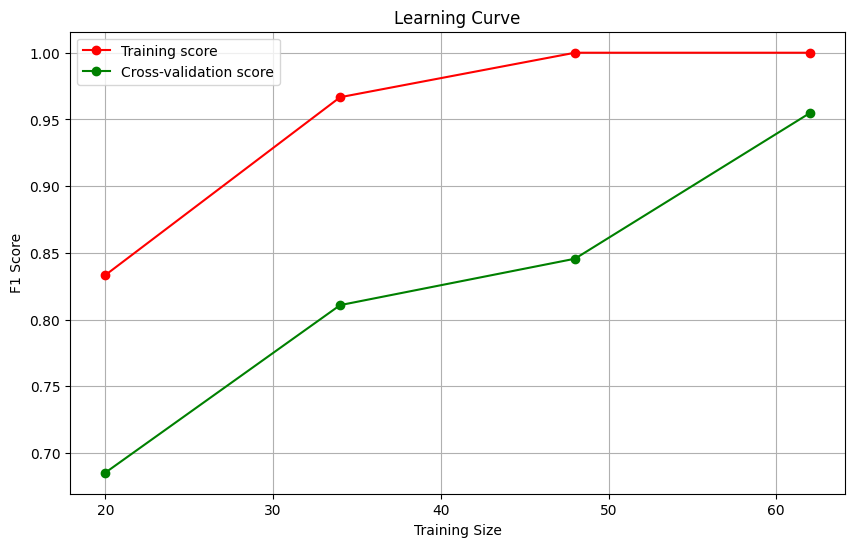

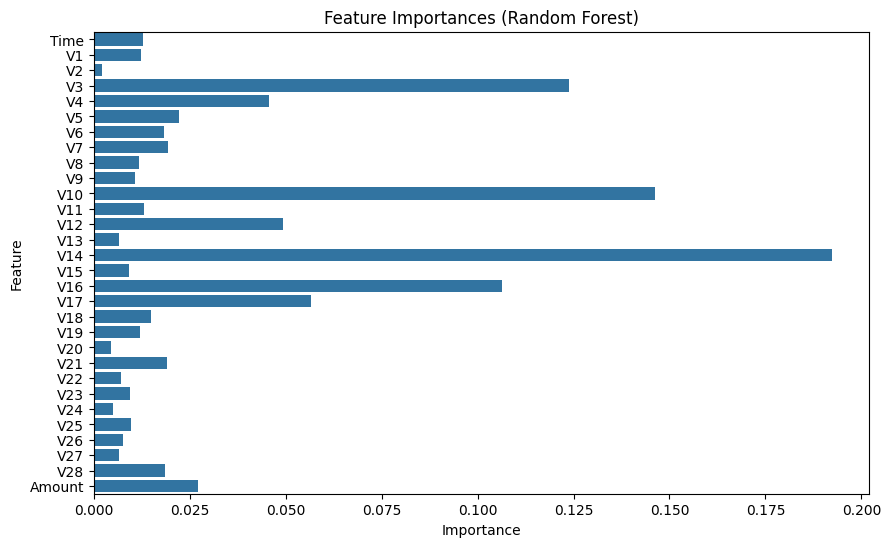

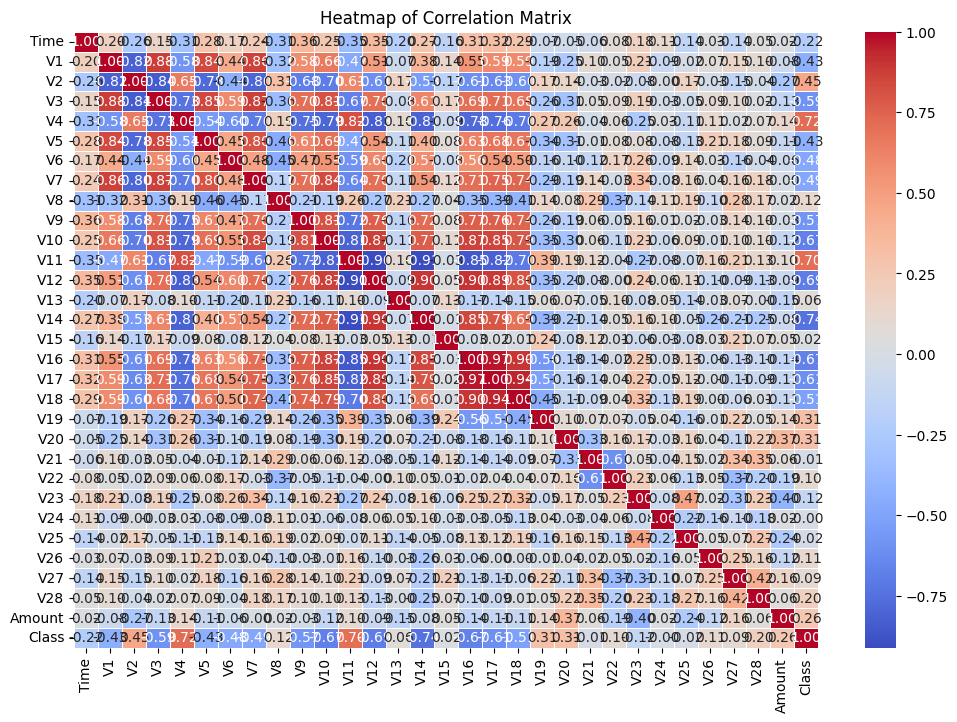

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

# Step 1: Load the dataset
data = pd.read_csv("/content/balanced_creditcard.csv")
data = data.dropna()  # Remove missing values

# Step 2: Sample the data for faster processing
sample_data = data.sample(frac=0.1, random_state=42)  # Use 10% of data

# Step 3: Separate features and target variable
X = sample_data.drop(columns=['Class'])
y = sample_data['Class']

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 7: Define the base models with class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svm = SVC(class_weight='balanced', probability=True, random_state=42)

# Parameter grids for each model for GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, None]
}

param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}

param_grid_svm = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Step 8: Use GridSearchCV to find the best parameters for each model
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
grid_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, scoring='f1', n_jobs=-1)
grid_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=3, scoring='f1', n_jobs=-1)

# Fit the grids
grid_rf.fit(X_train_resampled, y_train_resampled)
grid_gb.fit(X_train_resampled, y_train_resampled)
grid_svm.fit(X_train_resampled, y_train_resampled)

# Best estimators from GridSearchCV
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_
best_svm = grid_svm.best_estimator_

# Step 9: Create the stacking ensemble model with the best models
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb),
        ('svm', best_svm)
    ],
    final_estimator=LogisticRegression(),
    cv=3,
    n_jobs=-1
)

# Step 10: Train the stacking model
stacking_model.fit(X_train_resampled, y_train_resampled)

# Step 11: Make predictions and evaluate the model
y_pred = stacking_model.predict(X_test)
y_proba = stacking_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC curve and threshold adjustment

# Step 12: Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the stacked model: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Step 13: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 14: Adjust probability threshold to improve recall
threshold = 0.3  # Adjusted threshold
y_pred_threshold = (y_proba >= threshold).astype(int)

# Recalculate metrics with adjusted threshold
print(f"Classification Report with threshold {threshold}:")
print(classification_report(y_test, y_pred_threshold, target_names=['Non-Fraud', 'Fraud']))

# Step 15: Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Step 16: Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Step 17: Plot learning curve for the stacking model
train_sizes, train_scores, test_scores = learning_curve(stacking_model, X_train_resampled, y_train_resampled, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring='f1')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Step 18: Plot feature importance for the RandomForest model
feature_importances = best_rf.feature_importances_
features = sample_data.columns[:-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 19: Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(sample_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()


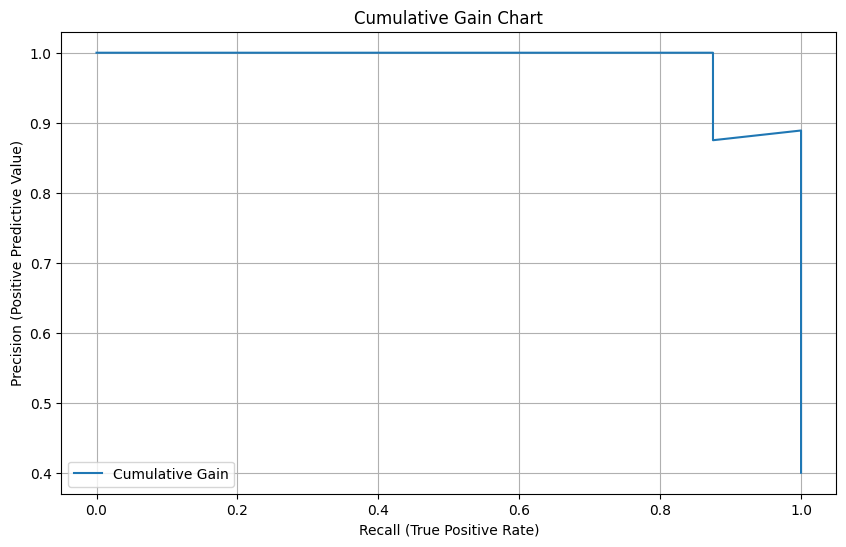

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_cumulative_gain(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label='Cumulative Gain')
    plt.xlabel('Recall (True Positive Rate)')
    plt.ylabel('Precision (Positive Predictive Value)')
    plt.title('Cumulative Gain Chart')
    plt.legend()
    plt.grid()
    plt.show()

plot_cumulative_gain(y_test, y_proba)


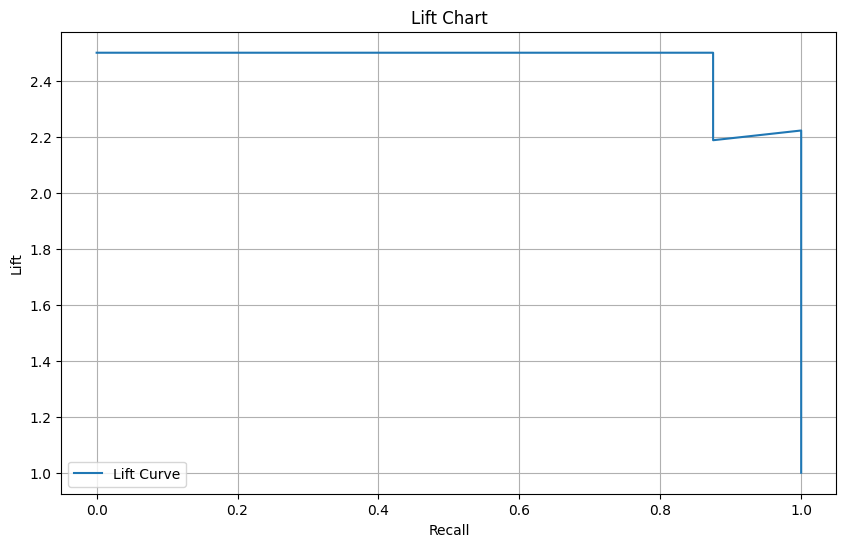

In [ ]:
def plot_lift_chart(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    lift = precision / (sum(y_true) / len(y_true))
    plt.figure(figsize=(10, 6))
    plt.plot(recall, lift, label='Lift Curve')
    plt.xlabel('Recall')
    plt.ylabel('Lift')
    plt.title('Lift Chart')
    plt.legend()
    plt.grid()
    plt.show()

plot_lift_chart(y_test, y_proba)


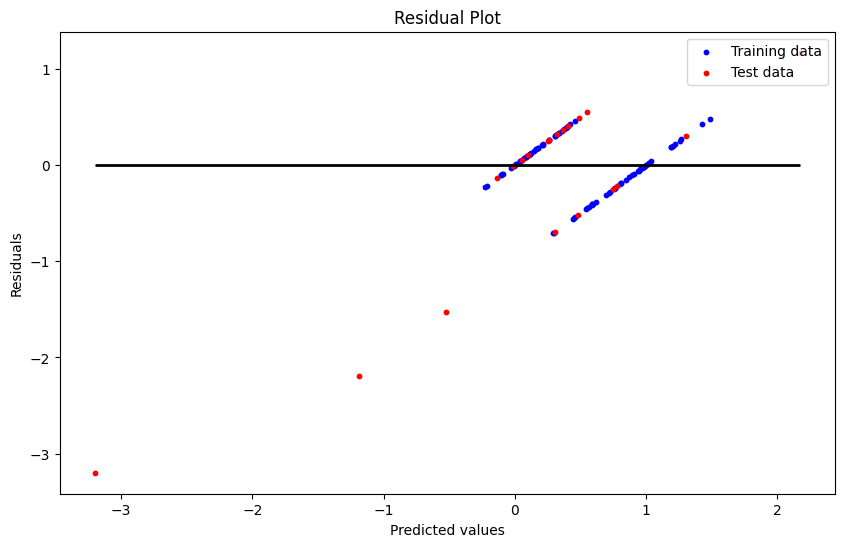

In [ ]:
from sklearn.linear_model import LinearRegression

# Example for regression
model = LinearRegression()
model.fit(X_train_resampled, y_train_resampled)
y_pred_train = model.predict(X_train_resampled)
y_pred_test = model.predict(X_test)

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_train, y_pred_train - y_train_resampled, color="blue", s=10, label="Training data")
plt.scatter(y_pred_test, y_pred_test - y_test, color="red", s=10, label="Test data")
plt.hlines(y=0, xmin=min(y_pred_test), xmax=max(y_pred_test), color="black", linewidth=2)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper right")
plt.show()
